In [135]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.ndimage import binary_dilation
# from skimage.morphology import dilation, disk
import scipy
import skimage
import cv2
import torch
import torch.nn.functional as F

In [145]:
def generate_separated_points(image_size, num_points, min_distance):
    points = []
    
    while len(points) < num_points:
        # Generate a candidate point
        x, y = np.random.randint(0, image_size[0]), np.random.randint(0, image_size[1])
        valid = True
        
        # Check the distance from this point to all previously selected points
        for px, py in points:
            if abs(x - px) < min_distance and abs(y - py) < min_distance:
                valid = False
                break
        
        # If valid, add the point to the list
        if valid:
            points.append((x, y))
    
    return points

def get_random_binary_image():
    image_size = np.array([1640, 1920])
    binary_image = np.zeros(image_size)
    
    # find ten pairs of random points
    points = generate_separated_points(image_size - 125, 10, 125)  
    x, y = zip(*points)
    for i in range(10):
        binary_image[x[i]:x[i] + 123, y[i]: y[i] + 123] = 1

    # plt.imshow(binary_image, cmap='gray')

    return binary_image

def compute_white_pixel_proportion(binary_image):
    # proportion of white pixels
    white_pixels = np.sum(binary_image == 1)
    total_pixels = binary_image.size
    return white_pixels*100 / total_pixels


binary_image = get_random_binary_image()

In [146]:
# Structuring element (e.g., a disk with radius 1)
structuring_element = skimage.morphology.disk(1)  # A disk of radius 1 pixel

# Dilate the white pixels
skimage_morphology_timing = %timeit -o dilated_image = skimage.morphology.dilation(binary_image, structuring_element)

27.7 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [147]:
# Structuring element (e.g., 3x3 square)
structuring_element = np.ones((4, 4), dtype=np.uint8)

# Dilate the white pixels
scipy_ndimage_timings = %timeit -o dilated_image = scipy.ndimage.binary_dilation(binary_image, structure=structuring_element)

99.8 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [148]:
# Structuring element (e.g., 3x3 square)
kernel = np.ones((4, 4), dtype=np.uint8)

# Dilate the white pixels
cv2_dilation_timings =  %timeit -o dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

10.1 ms ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [149]:
binary_image_tensor = torch.tensor(binary_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
# Structuring element (kernel, e.g., 3x3 square)
kernel = torch.ones((1, 1, 3, 3), dtype=torch.float32)

# Perform dilation using 2D convolution
torch_convolution_timings = %timeit -o dilated_image_tensor = (F.conv2d(binary_image_tensor, kernel, padding=1) > 0).float()

32 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


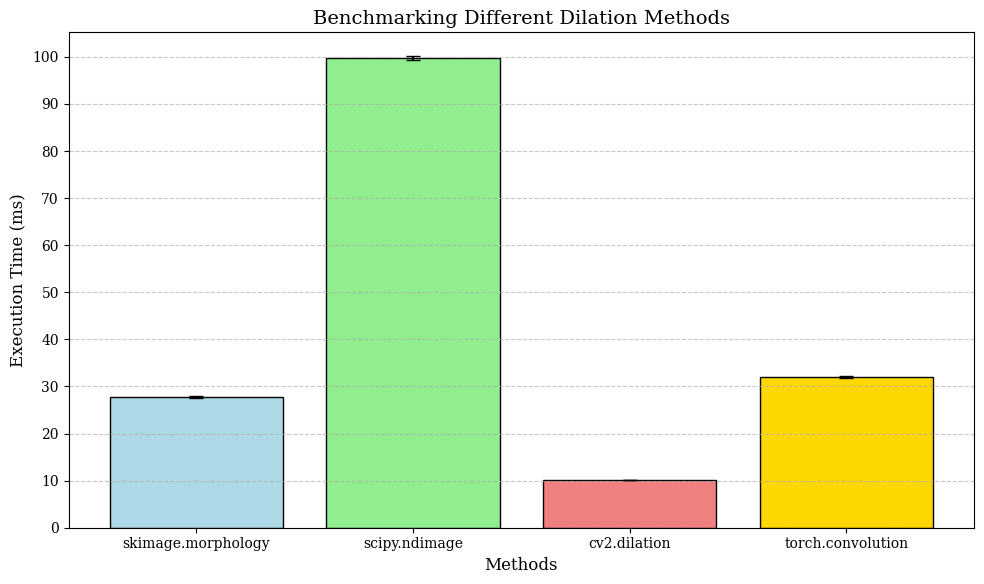

In [158]:
plt.rcParams

# Collect data into a dictionary for easier processing
timing_data = {
    "skimage.morphology": {"mean": skimage_morphology_timing.average*1000, "std": skimage_morphology_timing.stdev*1000},
    "scipy.ndimage": {"mean": scipy_ndimage_timings.average*1000, "std": scipy_ndimage_timings.stdev*1000},
    "cv2.dilation": {"mean": cv2_dilation_timings.average*1000, "std": cv2_dilation_timings.stdev*1000},
    "torch.convolution": {"mean": torch_convolution_timings.average*1000, "std": torch_convolution_timings.stdev*1000},
}

# Extract data for plotting
methods = list(timing_data.keys())
means = [timing_data[method]["mean"] for method in methods]
std_devs = [timing_data[method]["std"] for method in methods]

# Define colors for each bar
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

# Set all fonts to serif
plt.rc('font', family='serif', size=12)

# Plotting with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, means, yerr=std_devs, capsize=5, color=colors, edgecolor='black')
plt.xlabel("Methods", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("Benchmarking Different Dilation Methods", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# make yticks go from 0 to 110 in steps of 10
plt.yticks(np.arange(0, 110, 10))

# Adding the y-axis explicitly in milliseconds
plt.ylabel("Execution Time (ms)")

plt.tight_layout()

# Display the plot
plt.show()







